In [1]:
import pandas as pd
import numpy as np
import time
import datetime
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras import callbacks
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

/Users/neil/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


## Early Data Exploration

In [2]:
df = pd.read_csv("historical_data.csv")
print("LENGTH OF DATASET: " + str(len(df)) + "\n")
print("NUMBER OF COLUMNS: " + str(len(df.columns)) + "\n")
print("COLUMN NAMES:")
for col in df.columns:
    print("  " + col + ": " + str(df[col].dtype))

LENGTH OF DATASET: 197428

NUMBER OF COLUMNS: 16

COLUMN NAMES:
  market_id: float64
  created_at: object
  actual_delivery_time: object
  store_id: int64
  store_primary_category: object
  order_protocol: float64
  total_items: int64
  subtotal: int64
  num_distinct_items: int64
  min_item_price: int64
  max_item_price: int64
  total_onshift_dashers: float64
  total_busy_dashers: float64
  total_outstanding_orders: float64
  estimated_order_place_duration: int64
  estimated_store_to_consumer_driving_duration: float64


In [3]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


## Missing Data

In [4]:
df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [5]:
cols = df.columns
for col in cols:
    pct = round(df[col].isnull().sum() / float(len(df)) * 100, 2)
    print(str(col) + ": " + str(pct) + "%")

market_id: 0.5%
created_at: 0.0%
actual_delivery_time: 0.0%
store_id: 0.0%
store_primary_category: 2.41%
order_protocol: 0.5%
total_items: 0.0%
subtotal: 0.0%
num_distinct_items: 0.0%
min_item_price: 0.0%
max_item_price: 0.0%
total_onshift_dashers: 8.24%
total_busy_dashers: 8.24%
total_outstanding_orders: 8.24%
estimated_order_place_duration: 0.0%
estimated_store_to_consumer_driving_duration: 0.27%


In [6]:
## data kept by droping all missing data
print("percent of data left after dropping all missing data: " + str(round(len(df.dropna())*100 / float(len(df)), 2)))

percent of data left after dropping all missing data: 89.03


In [7]:
df.dropna(inplace=True)
len(df)

175777

## Alternatives to Dropping Missing Rows
#### Imputing Mean, Median (for continuous columns), or Mode (for discrete columns)
#### Build a regression/classification model for each feature based on the remaining features

---

## Create Target

In [8]:
def convert_to_ts(x):
    x = time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple())
    return x

df['create_ts'] = df.created_at.apply(lambda x: convert_to_ts(x))
df['delivery_ts'] = df.actual_delivery_time.apply(lambda x: convert_to_ts(x))
df['target'] = df.delivery_ts - df.create_ts

## Feature Engineering

### Hour of Day

In [9]:
df['hour'] = df.created_at.apply(lambda x: x.split(" ")[1].split(":")[0])
df.drop(['create_ts', 'delivery_ts', 'created_at', 'actual_delivery_time'], axis=1, inplace=True)
df.head()

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,target,hour
0,1.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,22
1,2.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,21
8,2.0,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,00
14,1.0,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0,03
15,1.0,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2988.0,02


### Percentage of Dashers Busy

In [10]:
df = df[df.total_onshift_dashers>0]
df['total_busy_dashers'] = df.total_busy_dashers.astype(float)
df['total_onshift_dashers'] = df.total_onshift_dashers.astype(float)
df['pct_dashers_busy'] = df.total_busy_dashers / df.total_onshift_dashers
## total busy dashers would be skewed by population of area, pct dashers busy helps normalize
df.drop(['total_busy_dashers'], axis=1, inplace=True)

## Value Counts

In [11]:
for col in df.columns:
    print(col.upper())
    print(df[col].value_counts())
    print("\n\n")

MARKET_ID
2.0    53426
4.0    46174
1.0    34930
3.0    19831
5.0    17227
6.0      627
Name: market_id, dtype: int64



STORE_ID
6865    923
1311    849
314     805
1686    754
3937    711
6917    660
6074    627
4367    578
3748    550
1409    538
6503    537
6313    532
1185    531
2056    531
6281    523
6525    493
1853    489
4210    486
6151    469
1661    447
4863    446
3620    444
3813    419
2494    395
3019    385
920     383
4862    383
2680    382
5839    378
5987    373
       ... 
1133      1
1005      1
3369      1
5546      1
2299      1
2141      1
578       1
877       1
424       1
1164      1
1062      1
3960      1
3408      1
3239      1
1318      1
3367      1
2700      1
994       1
3576      1
604       1
338       1
6180      1
6623      1
5344      1
2060      1
3907      1
850       1
1420      1
1106      1
4795      1
Name: store_id, dtype: int64



STORE_PRIMARY_CATEGORY
american             17867
pizza                15494
mexican              15430
bu

In [12]:
## add discrete columns to a list
discrete = ['market_id', 'store_id', 'store_primary_category', 'order_protocol', 'hour']
continuous = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'pct_dashers_busy']

## Check for Data Correctness

In [13]:
for col in continuous:
    print(col)
    print(df[col].min())
    print(df[col].max())
    print("\n")

total_items
1
411


subtotal
0
26800


num_distinct_items
1
20


min_item_price
-86
14700


max_item_price
0
14700


total_onshift_dashers
1.0
171.0


total_outstanding_orders
-6.0
285.0


estimated_order_place_duration
0
2715


estimated_store_to_consumer_driving_duration
0.0
2088.0


pct_dashers_busy
-2.0
31.0




In [14]:
for col in continuous + ['target']:
    df[col] = df[col].astype(float)

In [15]:
print("total rows: " + str(len(df)))

total rows: 172215


In [16]:
print("total rows after dropping incorrect entries: " + str(len(df[(df.subtotal>0) & (df.min_item_price>0) & (df.max_item_price>0) & (df.total_onshift_dashers>=0) & (df.total_outstanding_orders>=0) & (df.estimated_store_to_consumer_driving_duration>0) & (df.target<14400) & (df.pct_dashers_busy>=0) & (df.pct_dashers_busy<=1)])))

total rows after dropping incorrect entries: 131127


In [17]:
# Decided it was better to remove columns rather than impute data being the amount of rows lost was small
df = df[(df.subtotal>0) & (df.min_item_price>0) & (df.max_item_price>0) & (df.total_onshift_dashers>=0) & (df.total_outstanding_orders>=0) & (df.estimated_store_to_consumer_driving_duration>0) & (df.target<14400) & (df.pct_dashers_busy>=0) & (df.pct_dashers_busy<=1)]

In [18]:
for col in continuous + ['target']:
    print(col)
    print(df[col].min())
    print(df[col].max())
    print("\n")

total_items
1.0
48.0


subtotal
125.0
22500.0


num_distinct_items
1.0
20.0


min_item_price
1.0
14700.0


max_item_price
75.0
14700.0


total_onshift_dashers
1.0
171.0


total_outstanding_orders
0.0
285.0


estimated_order_place_duration
0.0
2715.0


estimated_store_to_consumer_driving_duration
3.0
1711.0


pct_dashers_busy
0.0
1.0


target
297.0
14214.0




## Convert Discrete Values to One Hot Vectors

In [19]:
def cut_discrete_vals(x, accepted_vals):
    if x in accepted_vals:
        return x
    return -1

for col in discrete:
    df[col].value_counts
    accepted_vals = list(df[col].value_counts()[df[col].value_counts()>30].index)
    df[col] = df[col].apply(lambda x: cut_discrete_vals(x, accepted_vals))
    df = pd.concat([df, pd.get_dummies(df[col], drop_first=True, prefix=col, prefix_sep="_")], axis='columns')
df.drop(discrete, axis=1, inplace=True)

In [20]:
df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,target,...,hour_06,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,4.0,3441.0,4.0,557.0,1239.0,33.0,21.0,446.0,861.0,3779.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,4.0,4771.0,3.0,820.0,1604.0,8.0,18.0,446.0,289.0,1586.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,2.0,3620.0,2.0,1425.0,2195.0,5.0,7.0,446.0,205.0,2988.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,3.0,4475.0,3.0,925.0,1825.0,4.0,1.0,446.0,542.0,5267.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,3.0,4375.0,3.0,1325.0,1625.0,6.0,3.0,446.0,789.0,4976.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Standardize Data

In [21]:
for col in continuous:
    mean = float(df[col].mean())
    sd = float(df[col].std())
    df[col] = df[col].apply(lambda x: (x - mean) / sd)
df[continuous].head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,pct_dashers_busy
0,0.381636,0.391333,0.824464,-0.261511,0.134598,-0.402753,-0.715654,1.529805,1.436136,-2.525822
8,0.381636,1.113341,0.206275,0.249153,0.790249,-1.101384,-0.770901,1.529805,-1.176603,-0.614299
15,-0.506797,0.488506,-0.411914,1.423875,1.851863,-1.185220,-0.973474,1.529805,-1.560292,0.852684
16,-0.062581,0.952654,0.206275,0.453030,1.187232,-1.213165,-1.083968,1.529805,-0.020968,-3.548265
17,-0.062581,0.898368,0.206275,1.229706,0.827971,-1.157275,-1.047137,1.529805,1.107259,-1.103293


## Handle Outliers

In [22]:
def handle_outliers(x):
    if (x > -3) & (x < 3):
        return x
    elif x >= 3:
        x = 3 + (x/10.0)
        if x > 4:
            x = 4
    elif x <= -3:
        x = -3 + (x/10.0)
        if x < -4:
            x = -4
    return x

for col in continuous:
    df[col] = df[col].apply(lambda x: handle_outliers(x))

In [23]:
df.shape

(131127, 1258)

## Check for Correlation Between Features

In [24]:
from itertools import combinations 
counter = 0
for pair in combinations(df.columns, 2):
    correlation = df[[pair[0], pair[1]]].corr().loc[pair[0], pair[1]]
    if (correlation > 0.9) | (correlation < -0.9):
        print(pair[0], pair[1], correlation)

('total_onshift_dashers', 'total_outstanding_orders', 0.9382248235854771)
('estimated_order_place_duration', 'order_protocol_1.0', 0.9090470784292836)
('store_id_3380', 'store_primary_category_nepalese', 0.9180133128570998)
('store_id_4810', 'store_primary_category_kosher', 0.963024960136397)


In [24]:
df.drop(['total_onshift_dashers', 'order_protocol_1.0', 'store_id_3380', 'store_id_4810'], axis=1, inplace=True)

## Split Data

In [27]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1), df.target, test_size=0.33)

## Model Construction

### Linear Regression

In [31]:
lr = LinearRegression(fit_intercept=True)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Linear Regression Root Mean Squared Error: " + str(mse**0.5))
print("Linear Regression Mean Squared Error: " + str(mse))
print("Linear Regression Mean Absolute Error: " + str(mae))
print("Linear Regression Median Absolute Error: " + str(mdae))

Linear Regression Root Mean Squared Error: 886.5609390525727
Linear Regression Mean Squared Error: 785990.2986537797
Linear Regression Mean Absolute Error: 636.1831781559818
Linear Regression Median Absolute Error: 501.09770975020615


### Random Forest

In [38]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=10, verbose=1, n_jobs=-1)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Random Forest Root Mean Squared Error: " + str(mse**0.5))
print("Random Forest Mean Squared Error: " + str(mse))
print("Random Forest Mean Absolute Error: " + str(mae))
print("Random Forest Median Absolute Error: " + str(mdae))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 20.8min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.8s finished


Random Forest Root Mean Squared Error: 919.5238285258702
Random Forest Mean Squared Error: 845524.0712268739
Random Forest Mean Absolute Error: 667.5307501459476
Random Forest Median Absolute Error: 536.355441059233


In [32]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=25, verbose=1, n_jobs=-1)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Random Forest Root Mean Squared Error: " + str(mse**0.5))
print("Random Forest Mean Squared Error: " + str(mse))
print("Random Forest Mean Absolute Error: " + str(mae))
print("Random Forest Median Absolute Error: " + str(mdae))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 28.6min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.8s finished


Random Forest Root Mean Squared Error: 904.1117751110995
Random Forest Mean Squared Error: 817418.1018945434
Random Forest Mean Absolute Error: 648.5085523629874
Random Forest Median Absolute Error: 509.8680400963117


In [37]:
rf = RandomForestRegressor(n_estimators=100, max_depth=None, verbose=1, n_jobs=-1)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Random Forest Root Mean Squared Error: " + str(mse**0.5))
print("Random Forest Mean Squared Error: " + str(mse))
print("Random Forest Mean Absolute Error: " + str(mae))
print("Random Forest Median Absolute Error: " + str(mdae))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


Random Forest Root Mean Squared Error: 908.9479413282845
Random Forest Mean Squared Error: 826186.3600449266
Random Forest Mean Absolute Error: 651.0093242595013
Random Forest Median Absolute Error: 507.34000000000015


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


### Support Vector Machine

In [33]:
## larger C emphasizes classifying most points correctly at the expense of the size of the decision boundary
## thus, larger C is more prone to overfitting
## smaller C puts an emphasis on maximizing distance of decision boundary
## tolerance is the reduced loss that is considered too small to continue training
svr = SVR(kernel='rbf', C=1.0, tol=0.0001)
svr.fit(x_train, y_train)

y_pred = svr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("SVM Root Mean Squared Error: " + str(mse**0.5))
print("SVM Mean Squared Error: " + str(mse))
print("SVM Mean Absolute Error: " + str(mae))
print("SVM Median Absolute Error: " + str(mdae))

SVM Root Mean Squared Error: 1044.7052464550782
SVM Mean Squared Error: 1091409.0519707655
SVM Mean Absolute Error: 746.5639206800552
SVM Median Absolute Error: 573.6788256760888


### Neural Network

In [34]:
num_features = len(x_train.columns)

model = Sequential()
model.add(Dense(num_features*2, input_dim=num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0)
callbacks_list = [stop]
model.fit(x_train, y_train, validation_split=0.33, callbacks=callbacks_list, epochs=100, batch_size=32, verbose=2)

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Neural Net Root Mean Squared Error: " + str(mse**0.5))
print("Neural Net Mean Squared Error: " + str(mse))
print("Neural Net Mean Absolute Error: " + str(mae))
print("Neural Net Median Absolute Error: " + str(mdae))

Train on 58862 samples, validate on 28993 samples
Epoch 1/100
 - 117s - loss: 1003264.8772 - mean_squared_error: 1003264.8772 - val_loss: 797945.4754 - val_mean_squared_error: 797945.4754
Epoch 2/100
 - 119s - loss: 794971.9203 - mean_squared_error: 794971.9203 - val_loss: 806386.2145 - val_mean_squared_error: 806386.2145
Neural Net Root Mean Squared Error: 893.3873517214637
Neural Net Mean Squared Error: 798140.9602158903
Neural Net Mean Absolute Error: 656.5406402458125
Neural Net Median Absolute Error: 534.0692138671875


In [36]:
num_features = len(x_train.columns)

model = Sequential()
model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_features*2, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0)
callbacks_list = [stop]
model.fit(x_train, y_train, validation_split=0.33, callbacks=callbacks_list, epochs=100, batch_size=32, verbose=2)

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Neural Net Root Mean Squared Error: " + str(mse**0.5))
print("Neural Net Mean Squared Error: " + str(mse))
print("Neural Net Mean Absolute Error: " + str(mae))
print("Neural Net Median Absolute Error: " + str(mdae))

Train on 58862 samples, validate on 28993 samples
Epoch 1/100
 - 85s - loss: 998951.5612 - mean_squared_error: 998951.5612 - val_loss: 812098.7683 - val_mean_squared_error: 812098.7683
Epoch 2/100
 - 86s - loss: 795183.9950 - mean_squared_error: 795183.9950 - val_loss: 789292.6941 - val_mean_squared_error: 789292.6941
Epoch 3/100
 - 85s - loss: 776299.6298 - mean_squared_error: 776299.6298 - val_loss: 806751.3384 - val_mean_squared_error: 806751.3384
Neural Net Root Mean Squared Error: 894.2215263630985
Neural Net Mean Squared Error: 799632.1382111496
Neural Net Mean Absolute Error: 663.2673789863777
Neural Net Median Absolute Error: 544.2381591796875


In [35]:
num_features = len(x_train.columns)

model = Sequential()
model.add(Dense(num_features*2, input_dim=num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0)
callbacks_list = [stop]
model.fit(x_train, y_train, validation_split=0.33, callbacks=callbacks_list, epochs=100, batch_size=32, verbose=2)

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Neural Net Root Mean Squared Error: " + str(mse**0.5))
print("Neural Net Mean Squared Error: " + str(mse))
print("Neural Net Mean Absolute Error: " + str(mae))
print("Neural Net Median Absolute Error: " + str(mdae))

Train on 58862 samples, validate on 28993 samples
Epoch 1/100
 - 146s - loss: 927879.2948 - mean_squared_error: 927879.2948 - val_loss: 840004.7361 - val_mean_squared_error: 840004.7361
Epoch 2/100
 - 138s - loss: 801669.6331 - mean_squared_error: 801669.6331 - val_loss: 920437.1086 - val_mean_squared_error: 920437.1086
Neural Net Root Mean Squared Error: 957.1747875631402
Neural Net Mean Squared Error: 916183.5739465426
Neural Net Mean Absolute Error: 745.26501727902
Neural Net Median Absolute Error: 644.6463623046875


## Top 75% of Features

## Feature Selection

In [36]:
top_features = list(SelectKBest(k=int(len(df.columns)*0.75)).fit(df.drop(['target'], axis=1), df.target).get_support(indices=True))
kbest_features = []
for idx in top_features:
    ftr = list(df.columns)[idx]
    if ftr == 'target':
        continue
    kbest_features.append(ftr)
    print(list(df.columns)[idx])

total_items
subtotal
num_distinct_items
min_item_price
max_item_price
total_outstanding_orders
estimated_order_place_duration
estimated_store_to_consumer_driving_duration
pct_dashers_busy
market_id_2.0
market_id_3.0
market_id_4.0
market_id_5.0
market_id_6.0
store_id_15
store_id_16
store_id_54
store_id_61
store_id_65
store_id_75
store_id_77
store_id_83
store_id_84
store_id_86
store_id_115
store_id_131
store_id_147
store_id_157
store_id_176
store_id_194
store_id_195
store_id_205
store_id_219
store_id_221
store_id_230
store_id_232
store_id_239
store_id_245
store_id_254
store_id_278
store_id_282
store_id_294
store_id_300
store_id_303
store_id_305
store_id_316
store_id_319
store_id_324
store_id_355
store_id_357
store_id_358
store_id_372
store_id_377
store_id_384
store_id_385
store_id_386
store_id_397
store_id_398
store_id_400
store_id_408
store_id_409
store_id_413
store_id_415
store_id_422
store_id_433
store_id_440
store_id_460
store_id_464
store_id_472
store_id_478
store_id_496
store_id_50

## Split Data

In [37]:
x_train, x_test, y_train, y_test = train_test_split(df[kbest_features], df.target, test_size=0.33)

## Linear Regression 75 %

In [38]:
lr = LinearRegression(fit_intercept=True)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Linear Regression Root Mean Squared Error: " + str(mse**0.5))
print("Linear Regression Mean Squared Error: " + str(mse))
print("Linear Regression Mean Absolute Error: " + str(mae))
print("Linear Regression Median Absolute Error: " + str(mdae))

Linear Regression Root Mean Squared Error: 911.4607768534732
Linear Regression Mean Squared Error: 830760.747742337
Linear Regression Mean Absolute Error: 649.1216877405767
Linear Regression Median Absolute Error: 510.8365216072043


## Random Forest 75 %

In [39]:
rf = RandomForestRegressor(n_estimators=100, max_depth=None, verbose=1, n_jobs=-1)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Random Forest Root Mean Squared Error: " + str(mse**0.5))
print("Random Forest Mean Squared Error: " + str(mse))
print("Random Forest Mean Absolute Error: " + str(mae))
print("Random Forest Median Absolute Error: " + str(mdae))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


Random Forest Root Mean Squared Error: 928.4413520203034
Random Forest Mean Squared Error: 862003.3441412889
Random Forest Mean Absolute Error: 661.6266254660442
Random Forest Median Absolute Error: 515.7399999999998


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


## Neural Network 75%

In [40]:
num_features = len(x_train.columns)

model = Sequential()
model.add(Dense(num_features*2, input_dim=num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0)
callbacks_list = [stop]
model.fit(x_train, y_train, validation_split=0.33, callbacks=callbacks_list, epochs=100, batch_size=32, verbose=2)

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Neural Net Root Mean Squared Error: " + str(mse**0.5))
print("Neural Net Mean Squared Error: " + str(mse))
print("Neural Net Mean Absolute Error: " + str(mae))
print("Neural Net Median Absolute Error: " + str(mdae))

Train on 58862 samples, validate on 28993 samples
Epoch 1/100
 - 57s - loss: 1054922.7286 - mean_squared_error: 1054922.7286 - val_loss: 799127.7578 - val_mean_squared_error: 799127.7578
Epoch 2/100
 - 57s - loss: 813164.4900 - mean_squared_error: 813164.4900 - val_loss: 779788.8305 - val_mean_squared_error: 779788.8305
Epoch 3/100
 - 59s - loss: 794719.7225 - mean_squared_error: 794719.7225 - val_loss: 781064.8201 - val_mean_squared_error: 781064.8201
Neural Net Root Mean Squared Error: 908.660447174354
Neural Net Mean Squared Error: 825663.8082590969
Neural Net Mean Absolute Error: 658.3432213051038
Neural Net Median Absolute Error: 527.5606079101562


## Top 90% of Features

In [41]:
top_features = list(SelectKBest(k=int(len(df.columns)*0.90)).fit(df.drop(['target'], axis=1), df.target).get_support(indices=True))
kbest_features = []
for idx in top_features:
    ftr = list(df.columns)[idx]
    if ftr == 'target':
        continue
    kbest_features.append(ftr)
    print(list(df.columns)[idx])

total_items
subtotal
num_distinct_items
min_item_price
max_item_price
total_outstanding_orders
estimated_order_place_duration
estimated_store_to_consumer_driving_duration
pct_dashers_busy
market_id_2.0
market_id_3.0
market_id_4.0
market_id_5.0
market_id_6.0
store_id_4
store_id_15
store_id_16
store_id_48
store_id_54
store_id_61
store_id_65
store_id_75
store_id_77
store_id_83
store_id_84
store_id_86
store_id_102
store_id_108
store_id_115
store_id_131
store_id_140
store_id_147
store_id_157
store_id_176
store_id_193
store_id_194
store_id_195
store_id_203
store_id_205
store_id_219
store_id_221
store_id_230
store_id_232
store_id_239
store_id_241
store_id_245
store_id_254
store_id_265
store_id_278
store_id_282
store_id_294
store_id_300
store_id_303
store_id_305
store_id_314
store_id_316
store_id_319
store_id_324
store_id_341
store_id_355
store_id_357
store_id_358
store_id_372
store_id_377
store_id_384
store_id_385
store_id_386
store_id_389
store_id_390
store_id_397
store_id_398
store_id_400
s

In [42]:
x_train, x_test, y_train, y_test = train_test_split(df[kbest_features], df.target, test_size=0.33)

## Linear Regression 90%

In [43]:
lr = LinearRegression(fit_intercept=True)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Linear Regression Root Mean Squared Error: " + str(mse**0.5))
print("Linear Regression Mean Squared Error: " + str(mse))
print("Linear Regression Mean Absolute Error: " + str(mae))
print("Linear Regression Median Absolute Error: " + str(mdae))

Linear Regression Root Mean Squared Error: 885.0919437696513
Linear Regression Mean Squared Error: 783387.7489259394
Linear Regression Mean Absolute Error: 638.8975251805176
Linear Regression Median Absolute Error: 503.7923534057064


## Random Forest 90%

In [44]:
rf = RandomForestRegressor(n_estimators=100, max_depth=None, verbose=1, n_jobs=-1)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Random Forest Root Mean Squared Error: " + str(mse**0.5))
print("Random Forest Mean Squared Error: " + str(mse))
print("Random Forest Mean Absolute Error: " + str(mae))
print("Random Forest Median Absolute Error: " + str(mdae))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


Random Forest Root Mean Squared Error: 905.2461190052027
Random Forest Mean Squared Error: 819470.5359739816
Random Forest Mean Absolute Error: 652.7120640874116
Random Forest Median Absolute Error: 511.75


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


## Neural Network 90%

In [45]:
num_features = len(x_train.columns)

model = Sequential()
model.add(Dense(num_features*2, input_dim=num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0)
callbacks_list = [stop]
model.fit(x_train, y_train, validation_split=0.33, callbacks=callbacks_list, epochs=100, batch_size=32, verbose=2)

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Neural Net Root Mean Squared Error: " + str(mse**0.5))
print("Neural Net Mean Squared Error: " + str(mse))
print("Neural Net Mean Absolute Error: " + str(mae))
print("Neural Net Median Absolute Error: " + str(mdae))

Train on 58862 samples, validate on 28993 samples
Epoch 1/100
 - 91s - loss: 1023143.7337 - mean_squared_error: 1023143.7337 - val_loss: 834856.3337 - val_mean_squared_error: 834856.3337
Epoch 2/100
 - 97s - loss: 804635.9335 - mean_squared_error: 804635.9335 - val_loss: 822102.0611 - val_mean_squared_error: 822102.0611
Epoch 3/100
 - 87s - loss: 786954.8175 - mean_squared_error: 786954.8175 - val_loss: 823792.1326 - val_mean_squared_error: 823792.1326
Neural Net Root Mean Squared Error: 884.3784427189834
Neural Net Mean Squared Error: 782125.229946054
Neural Net Mean Absolute Error: 636.1392856851085
Neural Net Median Absolute Error: 495.3782958984375


## Neural Network 90% - Added Early Stopping Patience 

In [52]:
num_features = len(x_train.columns)

model = Sequential()
model.add(Dense(num_features*2, input_dim=num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0)
callbacks_list = [stop]
model.fit(x_train, y_train, validation_split=0.33, callbacks=callbacks_list, epochs=100, batch_size=32, verbose=2)

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)

print("Neural Net Root Mean Squared Error: " + str(mse**0.5))
print("Neural Net Mean Squared Error: " + str(mse))
print("Neural Net Mean Absolute Error: " + str(mae))
print("Neural Net Median Absolute Error: " + str(mdae))

Train on 58862 samples, validate on 28993 samples
Epoch 1/100
 - 91s - loss: 1019669.9947 - mean_squared_error: 1019669.9947 - val_loss: 893069.7169 - val_mean_squared_error: 893069.7169
Epoch 2/100
 - 91s - loss: 803340.1117 - mean_squared_error: 803340.1117 - val_loss: 828813.2635 - val_mean_squared_error: 828813.2635
Epoch 3/100
 - 90s - loss: 786644.2472 - mean_squared_error: 786644.2472 - val_loss: 836608.0754 - val_mean_squared_error: 836608.0754
Epoch 4/100
 - 85s - loss: 773301.6930 - mean_squared_error: 773301.6930 - val_loss: 824119.4528 - val_mean_squared_error: 824119.4528
Epoch 5/100
 - 87s - loss: 764982.1713 - mean_squared_error: 764982.1713 - val_loss: 818078.9914 - val_mean_squared_error: 818078.9914
Epoch 6/100
 - 89s - loss: 753445.9811 - mean_squared_error: 753445.9811 - val_loss: 819880.6840 - val_mean_squared_error: 819880.6840
Epoch 7/100
 - 85s - loss: 745058.3070 - mean_squared_error: 745058.3070 - val_loss: 825256.6284 - val_mean_squared_error: 825256.6284
Epo

## Comparing Error

In [57]:
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

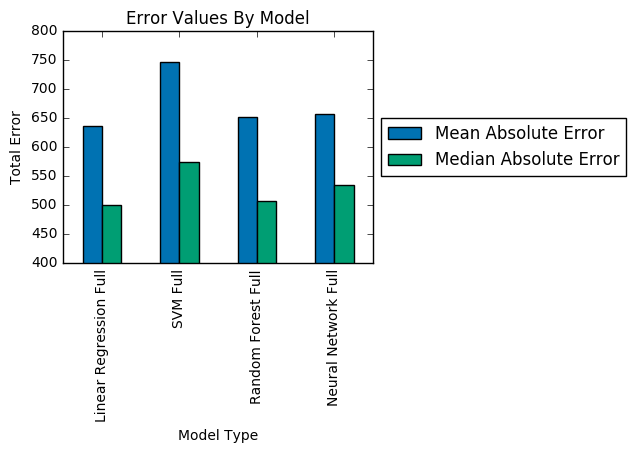

In [63]:
error_df = [['Linear Regression Full', 636.2, 501.1], ['SVM Full', 746.6, 573.7], ["Random Forest Full", 651.0, 507.3], ["Neural Network Full", 656.5, 534.1]]
error_df = pd.DataFrame(error_df, columns=['model', 'Mean Absolute Error', 'Median Absolute Error'])
error_df.set_index("model").plot(kind='bar', figsize=(4,3))
style.use('seaborn-colorblind')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Error Values By Model")
plt.ylabel("Total Error")
plt.xlabel("Model Type")
plt.ylim(400)
plt.savefig("error.png")

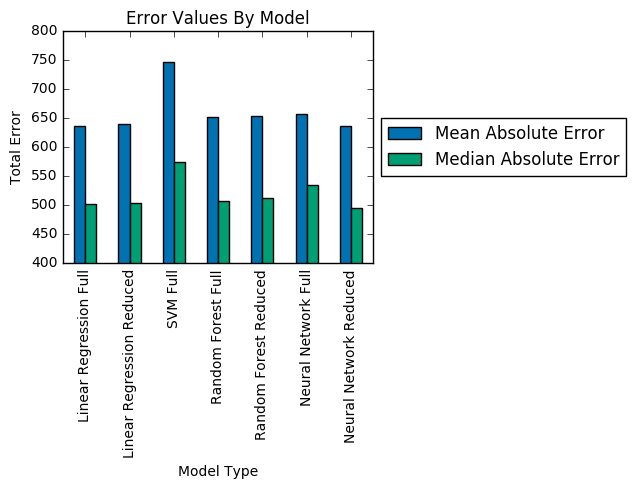

In [64]:
error_df = [['Linear Regression Full', 636.2, 501.1], ["Linear Regression Reduced", 638.9, 503.8], ['SVM Full', 746.6, 573.7], ["Random Forest Full", 651.0, 507.3], ["Random Forest Reduced", 652.7, 511.8], ["Neural Network Full", 656.5, 534.1], ["Neural Network Reduced", 636.1, 495.4]]
error_df = pd.DataFrame(error_df, columns=['model', 'Mean Absolute Error', 'Median Absolute Error'])
error_df.set_index("model").plot(kind='bar', figsize=(4,3))
style.use('seaborn-colorblind')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Error Values By Model")
plt.ylabel("Total Error")
plt.xlabel("Model Type")
plt.ylim(400)
plt.savefig("error.png")

## Further Analysis

In [44]:
df = pd.read_csv("historical_data.csv")
df.dropna(inplace=True)
df['create_ts'] = df.created_at.apply(lambda x: convert_to_ts(x))
df['delivery_ts'] = df.actual_delivery_time.apply(lambda x: convert_to_ts(x))
df['target'] = df.delivery_ts - df.create_ts
df['hour'] = df.created_at.apply(lambda x: x.split(" ")[1].split(":")[0])
df.drop(['create_ts', 'delivery_ts', 'created_at', 'actual_delivery_time'], axis=1, inplace=True)
df = df[df.total_onshift_dashers>0]
df['total_busy_dashers'] = df.total_busy_dashers.astype(float)
df['total_onshift_dashers'] = df.total_onshift_dashers.astype(float)
df['pct_dashers_busy'] = df.total_busy_dashers / df.total_onshift_dashers
## total busy dashers would be skewed by population of area, pct dashers busy helps normalize
df.drop(['total_busy_dashers'], axis=1, inplace=True)
df = df[(df.subtotal>0) & (df.min_item_price>0) & (df.max_item_price>0) & (df.total_onshift_dashers>=0) & (df.total_outstanding_orders>=0) & (df.estimated_store_to_consumer_driving_duration>0) & (df.target<14400) & (df.pct_dashers_busy>=0) & (df.pct_dashers_busy<=1)]
#for col in discrete:
#    df[col].value_counts
#    accepted_vals = list(df[col].value_counts()[df[col].value_counts()>30].index)
#    df[col] = df[col].apply(lambda x: cut_discrete_vals(x, accepted_vals))
#    df = pd.concat([df, pd.get_dummies(df[col], drop_first=True, prefix=col, prefix_sep="_")], axis='columns')
#df.drop(discrete, axis=1, inplace=True)

## Stores with Long Delivery Time

In [121]:
df.sort_values("target", ascending=False).target

163629    14214.0
127760    14207.0
116308    14035.0
182367    13990.0
156918    13855.0
55987     13781.0
36349     13774.0
79560     13625.0
189463    13446.0
98763     13366.0
120282    13277.0
15309     13164.0
193121    13133.0
5567      13036.0
182665    12949.0
65727     12939.0
180015    12891.0
111999    12842.0
186127    12746.0
40046     12539.0
151119    12476.0
58583     12450.0
130314    12337.0
63508     12182.0
78037     11951.0
100113    11907.0
75740     11857.0
43286     11708.0
24151     11647.0
125068    11639.0
           ...   
22619       664.0
140285      656.0
194547      655.0
57987       644.0
92268       641.0
15155       632.0
23628       630.0
186241      626.0
111979      619.0
36922       618.0
150093      616.0
120371      612.0
134818      610.0
175950      607.0
169814      596.0
57699       586.0
87769       583.0
118392      575.0
122082      563.0
173094      559.0
194711      542.0
169792      531.0
131899      516.0
101941      515.0
78374     

In [56]:
#average wait time by store_id, sort in descending order
print("average delivery time: " + str(round(df.target.mean())))
pd.DataFrame(df.groupby('store_id').target.mean()).sort_values('target', ascending=False).head(10)

average delivery time: 2819.0


,target
store_id,
974,9630.0
2426,8617.0
3259,8245.0
4934,7922.0
6956,7699.0
1085,7674.0
3437,7181.0
1070,6816.0
2241,6744.0


## Food Category with Long Delivery Time

In [55]:
#average wait time by store_primary_category, sort in descending order
print("average delivery time: " + str(round(df.target.mean())))
pd.DataFrame(df.groupby('store_primary_category').target.mean()).sort_values("target", ascending=False).head(10)

average delivery time: 2819.0


,target
store_primary_category,
caribbean,3363.000000
southern,3306.777778
belgian,3299.500000
brazilian,3270.193069
comfort-food,3186.600000
malaysian,3178.971014
burmese,3129.907843
tapas,3107.313725
steak,3079.063052


## Food Category with Quick Delivery Time

In [57]:
#average wait time by store_primary_category, sort in descending order
print("average delivery time: " + str(round(df.target.mean())))
pd.DataFrame(df.groupby('store_primary_category').target.mean()).sort_values("target").head(10)

average delivery time: 2819.0


,target
store_primary_category,
chocolate,2048.000000
kosher,2373.658537
convenience-store,2565.328829
fast,2581.952276
sandwich,2605.784283
smoothie,2622.547841
mexican,2625.011900
breakfast,2629.316680
persian,2636.586957


## Relationship of Percentage Dashers Busy and Delivery Time isn't as strong as Expected

In [58]:
## relationship between pct dashers busy and delivery time
df[['pct_dashers_busy', 'target']].corr()

,pct_dashers_busy,target
pct_dashers_busy,1.000000,0.204811
target,0.204811,1.000000


## Hour of Day Correlates Strongly to 

In [60]:
## groupby hour and find average of pct_dashers_busy at each hour bin (make a plot)
## UTC to PST, at time of dataset was 8 hour differnce --- 02 corresponds to 6pm
df.groupby('hour').target.mean().sort_values(ascending=False)

hour
02    3253.663288
03    3071.434135
15    2949.694370
01    2905.216841
16    2774.451827
19    2746.206611
17    2623.541470
20    2608.836639
00    2588.306538
04    2571.520286
23    2515.117837
22    2441.113492
18    2408.753663
06    2394.025676
21    2386.850732
05    2357.331314
07    2344.285714
14    2199.666667
Name: target, dtype: float64

In [66]:
pd.concat([df.target, pd.get_dummies(df['hour'], prefix=col, prefix_sep="_")], axis=1).corr()

,target,pct_dashers_busy_00,pct_dashers_busy_01,pct_dashers_busy_02,pct_dashers_busy_03,pct_dashers_busy_04,pct_dashers_busy_05,pct_dashers_busy_06,pct_dashers_busy_07,pct_dashers_busy_14,pct_dashers_busy_15,pct_dashers_busy_16,pct_dashers_busy_17,pct_dashers_busy_18,pct_dashers_busy_19,pct_dashers_busy_20,pct_dashers_busy_21,pct_dashers_busy_22,pct_dashers_busy_23
target,1.000000,-0.058100,0.035734,0.205337,0.091389,-0.058618,-0.073255,-0.030100,-0.003261,-0.003940,0.006594,-0.004470,-0.024668,-0.065592,-0.019186,-0.058186,-0.097752,-0.073376,-0.058338
pct_dashers_busy_00,-0.058100,1.000000,-0.117429,-0.134432,-0.102942,-0.067606,-0.045249,-0.020200,-0.001959,-0.001814,-0.014321,-0.028892,-0.036040,-0.045601,-0.075577,-0.079051,-0.064511,-0.055386,-0.054775
pct_dashers_busy_01,0.035734,-0.117429,1.000000,-0.219575,-0.168142,-0.110425,-0.073908,-0.032993,-0.003200,-0.002963,-0.023391,-0.047191,-0.058867,-0.074482,-0.123444,-0.129118,-0.105369,-0.090465,-0.089467
pct_dashers_busy_02,0.205337,-0.134432,-0.219575,1.000000,-0.192487,-0.126414,-0.084609,-0.037771,-0.003663,-0.003392,-0.026778,-0.054024,-0.067390,-0.085266,-0.141317,-0.147813,-0.120625,-0.103563,-0.102421
pct_dashers_busy_03,0.091389,-0.102942,-0.168142,-0.192487,1.000000,-0.096803,-0.064791,-0.028923,-0.002805,-0.002597,-0.020506,-0.041369,-0.051604,-0.065293,-0.108215,-0.113189,-0.092370,-0.079305,-0.078430
pct_dashers_busy_04,-0.058618,-0.067606,-0.110425,-0.126414,-0.096803,1.000000,-0.042551,-0.018995,-0.001842,-0.001706,-0.013467,-0.027169,-0.033891,-0.042881,-0.071069,-0.074336,-0.060663,-0.052083,-0.051508
pct_dashers_busy_05,-0.073255,-0.045249,-0.073908,-0.084609,-0.064791,-0.042551,1.000000,-0.012713,-0.001233,-0.001142,-0.009013,-0.018184,-0.022683,-0.028700,-0.047567,-0.049753,-0.040602,-0.034859,-0.034475
pct_dashers_busy_06,-0.030100,-0.020200,-0.032993,-0.037771,-0.028923,-0.018995,-0.012713,1.000000,-0.000550,-0.000510,-0.004024,-0.008118,-0.010126,-0.012812,-0.021234,-0.022210,-0.018125,-0.015561,-0.015390
pct_dashers_busy_07,-0.003261,-0.001959,-0.003200,-0.003663,-0.002805,-0.001842,-0.001233,-0.000550,1.000000,-0.000049,-0.000390,-0.000787,-0.000982,-0.001243,-0.002059,-0.002154,-0.001758,-0.001509,-0.001493
pct_dashers_busy_14,-0.003940,-0.001814,-0.002963,-0.003392,-0.002597,-0.001706,-0.001142,-0.000510,-0.000049,1.000000,-0.000361,-0.000729,-0.000909,-0.001150,-0.001907,-0.001994,-0.001628,-0.001397,-0.001382


In [59]:
## groupby hour and find average of pct_dashers_busy at each hour bin (make a plot)
df.groupby('hour').pct_dashers_busy.mean().sort_values(ascending=False)

hour
19    0.895767
03    0.894295
20    0.890990
02    0.874708
04    0.863420
01    0.855254
21    0.818535
05    0.815138
00    0.810834
23    0.799820
17    0.799609
22    0.792740
18    0.791771
16    0.776409
07    0.775907
06    0.743892
15    0.641066
14    0.416667
Name: pct_dashers_busy, dtype: float64